# TP 6 Réseaux de neurones - Multi classification et Propagation en arrière
Dans ce TP, nous aimerions entrainer un réseau de neurones pour la tâche de classification en utilisant l'algorithme d propagation en arrière (backpropagation).

L'ensemble de données que nous allons utiliser est le même que celui utilisé durant le TP1, i.e. les images de chiffres manuscrits.


# Importation des librairies necessaires au travail

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import cv2 

# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [3]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
data.shape

(5000, 401)

Dans ces données (data), les 400 premières colonnes representent les pixels de l'image (20x20), la dernière colonne represente la classe de l'image (chiffres de 0 à 9). (http://yann.lecun.com/exdb/mnist/)

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [4]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,:-1]))
y=data[:,-1]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [5]:
print('X', X.shape ,' y ', y.shape)

X (5000, 401)  y  (5000, 1)


Visualisation aléatoire de quelques données

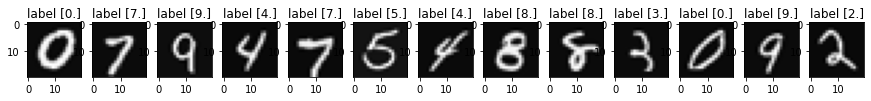

In [6]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,1:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(y[c]))
    plt.imshow(a,cmap='gray')

Transformer y de tel sorte à avoir un vecteur pour chaque exemple

Equivalent de tocategorical

In [7]:
YY=np.zeros((y.shape[0], int(np.max(y))+1))
YY.shape
y

array([[0.],
       [0.],
       [0.],
       ...,
       [9.],
       [9.],
       [9.]])

In [8]:
for i in range (YY.shape[0]):
    YY[i,int(y[i])]=1

print(YY)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


# Réseaux de neurones
Pour cette partie, nous choisissons une réseau simple:

- une couche d'entrée avec 400 noeuds (20 x 20 pixels) + le biais
- une couche cachée avec 25 noeuds
- une couche de sortie avec 10 noeuds (nombre de classes)

In [9]:
# poids de la couche 1
W1 = np.genfromtxt('W1.csv', delimiter=',', dtype=float)
W1.shape


(25, 401)

In [10]:
# poids de la couche 2
W2 = np.genfromtxt('W2.csv', delimiter=',', dtype=float)
W2.shape

(10, 26)

In [11]:
input_layer_size  = 400;  
hidden_layer_size = 25;   
num_labels = 10;

# Calcul du coût

# TODO  1 calcul du coût
**Tâche 1**: Modifier la fonction computeCost afin d'obtenir un coût avec régularisation

Rappelons que le coût avec régularisation est calculé comme suit:

$ J(\theta)= \frac{1}{m} \sum_{i=1}^m\sum_{k=1}^K \left[ -y_k^{(i)} \log (h_\theta(x^{(i)}) )_k - (1-y_k^{(i)}) \log (1-h_\theta(x^{(i)}) )_k \right] + \frac{\lambda}{2m} \left[ \sum_{j=1}^{25}\sum_{k=1}^{400} \left( \theta_{j,k}^{(1)} \right)^2 +   \sum_{j=1}^{10}\sum_{k=1}^{25} \left( \theta_{j,k}^{(2)} \right)^2 \right] $

In [12]:
def Sigmoid(z):
    return 1/(1+np.exp(-z));

In [13]:
def computeCost(X, YY, theta1, theta2,hidden_layer_size, lambda_):
    a1=X; 

    z2= np.zeros((X.shape[0],hidden_layer_size))
    a2= np.zeros((X.shape[0],hidden_layer_size)) 

    intercept=np.ones((X.shape[0],1))
    z2=np.column_stack((intercept,np.matmul(a1,np.transpose(theta1))))
    a2=Sigmoid(z2)
    a2[:,0]=1

    z3= np.zeros((YY.shape[0],YY.shape[1]))    
    a3= np.zeros((YY.shape[0],YY.shape[1]))  

    z3=np.matmul(a2,np.transpose(theta2))
    a3=Sigmoid(z3)

    J=np.zeros((YY.shape[0],1))
    J= (1/y.shape[0])*(np.sum(np.sum((-YY*np.log(a3))-((1-YY)*np.log(1-a3))))) + (lambda_/2*y.shape[0]) * ((np.sum(theta1**2) + np.sum(theta2**2)))

    return J

# TODO  2 calcul du gradient
**Tâche 2**: Implémenter la fonction NNCostFunction afin de retourner:

- Le coût avec régularisation
- Le gardient du coût par rapport à chaqu'un des paramètres du réseau

Rappelons le gradient de la sigmoid:

$ sigmoid(z) =\sigma(z)= \frac{1}{1-e^{-z}}$

$ \sigma(z)^\prime = \sigma(z)(1-\sigma(z)) =a(1-a)$ tel que $a$ est l'activation d'une couche donnée

L'algorithme à implementer est comme suit:

Pour chaque exemple de l'ensemble d'apprentissage faire

Pour chaque noeud de la couche de sortie, calculer la dérivée (gradient):

$\delta_k^{(3)} = \left( a_k^{(3)}- y_k \right)  $

Pour chaque noeud de la couche caché calculer la dérivée (gradient):

$\delta^{(2)} =  \left(\Theta^{(2)}\right)^T \delta^{(3)} \quad .* \quad \sigma^\prime\left(z^{(2)} \right) $

Notons que l'opérateur $.*$ represente la multiplication élement par élement et non pas la multiplication matricielle

Le gradient de chaque noeud et de chaque couche sera finalement:

$\Delta^{(l)} =  \Delta^{(l)} + \delta^{(l)} * \left( a^{(l)} \right)^T $

Fin pour

Fin pour

Diviser le gradient cumulé par le nombre d'exemples:

$ \frac{\partial J(\Theta)} { \partial \Theta_{i,j)}^{(l)}} = \frac{1}{m} \Delta_{i,j)}^{(l)}$


In [14]:
def NNCostFunction(X, YY, theta1, theta2,hidden_layer_size, lambda_):
    
    output1 = Sigmoid(X @ theta1.T) ##5000x25
    intercept=np.ones((data.shape[0],1))
    output1=np.column_stack((intercept, output1)) ##5000x26
    output2 = Sigmoid(output1 @ theta2.T) ## 5000*10
    output2 = output2 - YY ## 5000*10

    output11 = ((output2 @ theta2) * output1 * (1 - output1))[:, 1:]

    reduction1 = theta1 * lambda_ / len(YY)
    reduction1[:,0] = 0

    reduction2 = theta2 * lambda_ / len(YY)
    reduction2[:,0] = 0

    gradient1 = (np.matmul(X.T,(output11)).T + reduction1/len(X)) / len(y)
    gradient2 = (np.matmul(output1.T,(output2)).T + reduction2/len(X)) / len(y)

    cost = computeCost(X, YY, theta1, theta2, hidden_layer_size, lambda_)

    return cost, [gradient1, gradient2]

    # return J, grad
theta1 = np.zeros((W1.shape[0], W1.shape[1])) ## 25x401
theta2 = np.zeros((W2.shape[0], W2.shape[1])) ## 10x26
X = X ## 5000x401
YY = YY ## 5000X10
NNCostFunction(X, YY, theta1, theta2,hidden_layer_size, 0)


(6.931471805599453,
 [array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  array([[0.4, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
          0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
         [0.4, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
          0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
         [0.4, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
          0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
         [0.4, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
          0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
         [0.4, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
          0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 

# TODO  3 entrainement du réseau
**Tâche 3**: Entrainer le réseau en utilisant la descente du gradient:
Ici il faudra reprendre l'algorithme de la descente du gradient afin de mettre à jour les paramètres du réseau


In [23]:
def gradientDescent(X, y, Theta, alpha, iterations, lambda_):
    # saved_theta =  []
    costs = np.zeros(iterations)
    for i in range(iterations):
        cost , gradient = NNCostFunction(X, y, Theta[0], Theta[1], hidden_layer_size, lambda_)
        Theta[0] = Theta[0] - alpha * gradient[0]
        Theta[1] = Theta[1] - alpha * gradient[1]
        costs[i] = cost
        
    return Theta, costs


In [75]:
iterations = 1500
alpha = 1.6
lambda_ = 0
theta1 = np.zeros((W1.shape[0], W1.shape[1])) 
theta2 = np.zeros((W2.shape[0], W2.shape[1]))
theta = [theta1, theta2]
theta, costs = gradientDescent(X, YY, theta, alpha, iterations, lambda_)

In [81]:
computeCost(X, YY, theta[0], theta[1], hidden_layer_size, lambda_)
theta[1].max()

5.928065910735564

# TODO 4 : Régularisation
Mettre à jour le calcul du coût en ajoutant le terme de régularisation et comparer les résultats (avec et sans régularisation)

In [30]:
theta_reg = [theta1, theta2]
lambda_ = 500
theta_reg, costs = gradientDescent(X, YY, theta_reg, alpha, iterations, lambda_ = 1)
computeCost(X, YY, theta_reg[0], theta_reg[1], hidden_layer_size, 0)

1.8638541240732993

# TODO 5 : Prédiction

Appliquer une propagation en avant en utilisant les paramètres données pour prédir les classes de l'ensemble d'apprentissage.



In [55]:
def maximum_indexes(y_hat):
    y_pred = np.zeros((y_hat.shape[0],1))
    for i in range(y_hat.shape[0]):
        max = 0
        for j in range(y_hat.shape[1]):
            if(y_hat[i,j] > y_hat[i,max]):
                max = j
        y_pred[i,0] = max
    return y_pred

In [60]:
def predict (W1, W2, X):
    output1 = Sigmoid(X @ W1.T)
    intercept = np.ones((X.shape[0],1))
    output2 = np.column_stack((intercept, output1))
    output2 = Sigmoid(output2 @ W2.T)
    y_pred = maximum_indexes(output2)
    return y_pred

In [76]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred = predict(theta[0], theta[1], X)
precision = np.mean(y==y_pred)*100
precision

87.14

# optionnel 1 : Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

In [68]:
from sklearn.neural_network import MLPClassifier
import random

clf = MLPClassifier(solver='sgd', alpha=0.01, activation='logistic', max_iter=4000,
hidden_layer_sizes=(25,), random_state=42)

clf.fit(X, YY)
y_pred = maximum_indexes(clf.predict(X))
precision_sk = np.mean(y==y_pred)*100

Sklearn succes rate: 0.0
Our neural network succes rate: 87.14


In [72]:
print("Sklearn succes rate:",precision_sk)
print("Our neural network succes rate:",precision)

Sklearn succes rate: 90.12
Our neural network succes rate: 87.14


# Optionnel 2 : Visualisation des poids
    
La visualisation de poids permet de voir quel partie du réseau est activé et pour quelle classe.
Il est possible de visulaiser les paramètres theta1 . 
Ceci peut se faire en utilisant un reshape de ces paramètres afin d'avoir 25 images de taille 20x20 (n'oubliez pas d'ignorer la premuère colonne, celle du biais)

In [146]:
def visualize_weights(theta):
    plt.figure(figsize=(20, 5))
    for i in range(theta.shape[0]):
        plt.subplot(2, 13, i + 1)
        plt.imshow(np.reshape(theta[i][1:], (20, 20)))

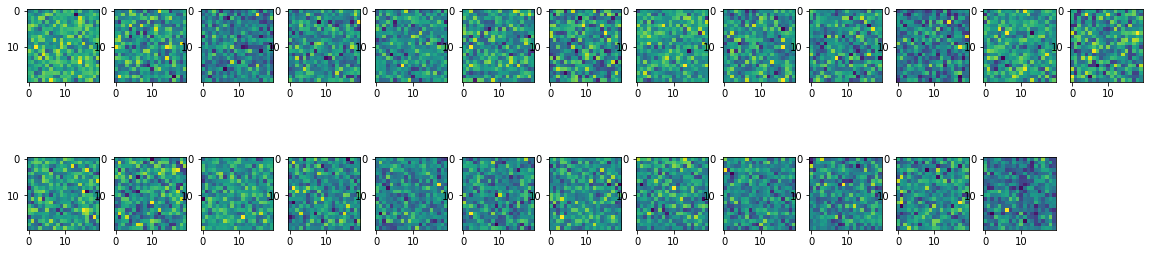

In [148]:
visualize_weights(theta[0])

# Optionnel 3 : Renforcement de l'apprentissage
Adjust theta starting interval with small values

In [91]:
iterations = 1000
alpha = 1.6
theta1 = np.random.normal(0, np.sqrt(1/200), W1.shape)
theta2 = np.random.normal(0, np.sqrt(1/20), W2.shape)
theta_adjusted = [theta1, theta2]
theta_adjusted, costs = gradientDescent(X, YY, theta_adjusted, alpha, iterations, lambda_)

In [93]:
y_pred = predict(theta_adjusted[0], theta_adjusted[1], X)
precision = np.mean(y==y_pred)*100
precision

96.96000000000001

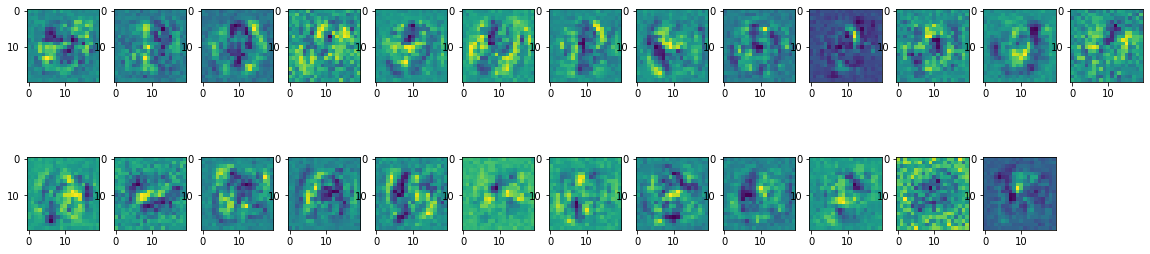

In [149]:
visualize_weights(theta_adjusted[0])

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 29Avril 2022 à 22h


In [ ]:
# bonne chance